In [1]:
%load_ext autoreload
%autoreload 2

In [48]:
from collections import namedtuple
import warnings

import torch as t
import numpy as np
import matplotlib.pyplot as plt

from transformers import GPT2TokenizerFast
from transformers.models.gpt2.tokenization_gpt2_fast import GPT2TokenizerFast

from gpt import GPT2, get_pretrained_gpt, Corruption, Patch
from hook_handler import HookHandler

In [51]:
gpt = get_pretrained_gpt()
gpt.eval();


GPT2(
  (token_embedding): Embedding(50257, 768)
  (pos_embedding): Embedding(1024, 768)
  (dropout): Dropout(p=0.1, inplace=False)
  (blocks): Sequential(
    (0): GPT2Block(
      (ln1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): UniAttention(
        (qkv_proj): Linear(in_features=768, out_features=2304, bias=True)
        (output_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ln2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (linear1): Linear(in_features=768, out_features=3072, bias=True)
      (linear2): Linear(in_features=3072, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): GPT2Block(
      (ln1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): UniAttention(
        (qkv_proj): Linear(in_features=768, out_features=2304, bias=True)
        (output_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ln2): LayerNorm((768,), eps=1

In [58]:
gpt.generate("The problem with modern culture is", temperature=.5)


"The problem with modern culture is that it is an ongoing process which involves changing the way we think about things. It's not a new thing, but it's something that has been"

In [3]:
gpt = load_weights(GPT2)
gpt.eval();
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')

In [12]:
device = "cuda" if t.cuda.is_available() else "cpu"
print(f"using {device}")
gpt.to(device);

using cuda


GPT2(
  (token_embedding): Embedding(50257, 768)
  (pos_embedding): Embedding(1024, 768)
  (dropout): Dropout(p=0.1, inplace=False)
  (blocks): Sequential(
    (0): GPT2Block(
      (ln1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): UniAttention(
        (qkv_proj): Linear(in_features=768, out_features=2304, bias=True)
        (output_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ln2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (linear1): Linear(in_features=768, out_features=3072, bias=True)
      (linear2): Linear(in_features=3072, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): GPT2Block(
      (ln1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): UniAttention(
        (qkv_proj): Linear(in_features=768, out_features=2304, bias=True)
        (output_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ln2): LayerNorm((768,), eps=1

In [4]:
def most_likely(model_out, k=5):
    target_probs = t.softmax(model_out.logits.squeeze(0), dim=0)
    top_probs, top_ids = t.topk(target_probs, k=k)
    for i in range(k):
        token = tokenizer.decode(top_ids[i])
        print(f"{repr(token).ljust(15)}{top_probs[i]:.2%}")

Baseline completions
' Paris'       6.37%
' London'      4.61%
' Amsterdam'   3.41%
' New'         3.18%
' Berlin'      2.61%


In [32]:
Fact = namedtuple("Fact", ['subject', 'relation', 'object'])
example_facts = [
    Fact("Lawrence Taylor", " professionally plays the sport of", " football"),
    Fact("The Eiffle Tower", " is in the city of", " Paris")
]

Input:
'Law' 'rence' ' Taylor' ' professionally' ' plays' ' the' ' sport' ' of' 

Prob ability of the correct answer (' football')
normal gpt: 7.35%
corrupted:  5.80%


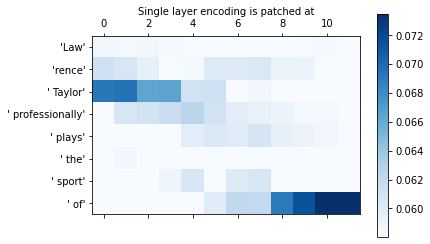

In [45]:
def get_correct_prob(out, correct_id):
    return t.softmax(out.logits[0], dim=-1)[correct_id].item()


def print_tokenized(ids):
    l = tokenizer.batch_decode([[id] for id in ids])
    for t in l:
        print(repr(t), end=" ")
    print()


def run_baseline(model, input_ids, correct_id):
    with HookHandler() as hh:
        for i, block in enumerate(model.blocks):
            hh.add_save_activation_hook(block, key=i)

        logits = model(input_ids)
        correct_prob = get_correct_prob(logits, correct_id)
        return hh.activations, correct_prob


def avg_evaluate(model, input_ids, correct_id, k=5, **kwargs):
    probs = []
    seeds = range(k)
    for seed in seeds:
        t.manual_seed(seed)
        corrupt_out = model.forward_corrupt_and_patch(input_ids, **kwargs)
        probs.append(get_correct_prob(corrupt_out, correct_id))
    return sum(probs) / k


def patching(
    model: GPT2, tokenizer, fact: Fact, k=10, noise_std=0.2, plot=True
):
    if fact.relation[0] != " ":
        warnings.warn(f"The fact relation {fact.relation} does not start with a space")
    if fact.object[0] != " ":
        warnings.warn(f"The fact object {fact.object} does not start with a space")

    subject_ids = tokenizer.encode(fact.subject, return_tensors="pt").to(device)
    relation_ids = tokenizer.encode(fact.relation, return_tensors="pt").to(device)
    subj_len = subject_ids.shape[1]
    input_ids = t.cat((subject_ids, relation_ids), dim=1)
    correct_id = tokenizer.encode(fact.object)
    if len(correct_id) != 1:
        warnings.warn(
            f"The fact object {fact.object} is {len(correct_id)} tokens long, only using first token"
        )
    correct_id = correct_id[0]

    activations, p_baseline = run_baseline(model, input_ids, correct_id)

    corruption = Corruption(subj_len, noise_std)
    p_corrupted = avg_evaluate(
        model,
        input_ids=input_ids,
        correct_id=correct_id,
        k=k,
        corruption=corruption,
    )
    
    print(f"Input:")
    print_tokenized(input_ids[0])

    print(f"\nProb ability of the correct answer ({repr(fact.object)})")
    print(f"normal gpt: {p_baseline:.2%}")
    print(f"corrupted:  {p_corrupted:.2%}")

    n_layers = len(model.blocks)
    n_tokens = input_ids.shape[1]
    avg_prob = np.zeros((n_tokens, n_layers))
    for token in range(n_tokens):
        for layer in range(n_layers):
            patch_value = activations[layer][0, token]
            patch = Patch(token=token, layer=layer, value=patch_value)
            prob = avg_evaluate(
                model,
                input_ids=input_ids,
                correct_id=correct_id,
                k=k,
                patch=patch,
                corruption=corruption,
            )
            avg_prob[token, layer] = prob

    if plot:
        plt.matshow(avg_prob, vmin=p_corrupted, vmax=p_baseline, cmap="Blues")
        l = tokenizer.batch_decode([[id] for id in input_ids[0]])
        plt.yticks(ticks=range(n_tokens), labels=[repr(t) for t in l])
        plt.xlabel("Single layer encoding is patched at")
        plt.gca().xaxis.set_label_position("top")
        plt.colorbar()
    return avg_prob


probs = patching(
    gpt, tokenizer, example_facts[0], k=10
)